In [26]:
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime, timedelta
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy
from sklearn.model_selection import train_test_split
from pyproj import CRS
import geopandas as gpd
import numpy as np
import pathlib
import os
import matplotlib.pyplot as plt
import random

In [2]:
def generate_grid(fire_file_path, centroid_x, centroid_y, is_label=False):
    fires = gpd.read_file(fire_file_path)
    fires = fires.to_crs(epsg=3310)

    # Get bounds of CRS
    x_min, y_min, x_max, y_max = (-5198207.57, -1564155.99, 6820717.07, 5283999.14)

    # Get the max polygon from shp file
    polygons = fires.geometry
    max_fire = None
    for polygon in polygons:
        if polygon is None:
            continue
        if not max_fire or polygon.area > max_fire.area:
            max_fire = polygon
            
    if max_fire is None:
        raise ValueError

    # Find centroid of that polygon
    # centroid_x = max_fire.centroid.x
    # centroid_y = max_fire.centroid.y

    # Generate points for each sqkm
    points = []

    topleft_x = int(centroid_x - 10000)
    topleft_y = int(centroid_y - 10000)

    for x in range(topleft_x, topleft_x + 20000, 1000):
        level = []
        for y in range(topleft_y, topleft_y + 20000, 1000):
            level.append(Point(x+500, y+500))
        points.append(level)

    # Generate boolean grid
    if is_label:
        grid = np.full((400,), 0.0)
    else:
        grid = np.full((402,), 0.0)
        # Add centroid feature
        grid[400] = (centroid_x - x_min) / (x_max - x_min)
#         print((centroid_x - x_min) / (x_max - x_min))
        grid[401] = (centroid_y - y_min) / (y_max - y_min)

    for i in range(len(points)):
        for j in range(len(points[i])):
            if max_fire.contains(points[i][j]):
                grid[i*20+j] = 1

    return grid

In [37]:
DATE_FORMAT_CODE = '%Y%m%d'

dataset_path = "./download/cleaned_fire_data/"

# data = []
# label = []

data = list(data)
label = list(label)

def preprocess(dataset_path):
    regions = os.listdir(dataset_path)
    for region in sorted(regions)[45:]:
        print(region)
        if region != '.DS_Store':
            date_path = os.path.join(dataset_path, region, 'GIS')
            dates = os.listdir(date_path)
            dates.sort() # Sort dates so that earliest date occur first
            dates.remove(".DS_Store")
            
            # Obtain centroid for first date
            fires = gpd.read_file(fire_file_path)
            fires = fires.to_crs(epsg=3310)
            polygons = fires.geometry
            max_fire = None
            for polygon in polygons:
                if polygon is None:
                    continue
                if not max_fire or polygon.area > max_fire.area:
                    max_fire = polygon
            
            # If first date does not have a fire, we skip the region
            if not max_fire:
                continue
                
            centroid_x = max_fire.centroid.x
            centroid_y = max_fire.centroid.y
            
            for i, date in enumerate(dates):
                # Check if 5 days in future exists
                date_time_obj = datetime.strptime(date, DATE_FORMAT_CODE)
                future_date_time_obj = date_time_obj + timedelta(days=5)
                future_date = future_date_time_obj.strftime(DATE_FORMAT_CODE)
                if future_date in dates:
                    fire_file_path = os.path.join(date_path, date)
                    future_fire_file_path = os.path.join(date_path, future_date)
                    fire_file_name = list(pathlib.Path(fire_file_path).glob('*.shp'))
                    future_fire_file_name = list(pathlib.Path(future_fire_file_path).glob('*.shp'))
                    # deal with currputed files
                    if not fire_file_name:
                        continue
                    if not future_fire_file_name:
                        continue
                    
                    try:
                        grid1 = generate_grid(fire_file_name[0], centroid_x, centroid_y, is_label=False)
                        grid2 = generate_grid(future_fire_file_name[0], centroid_x, centroid_y, is_label=True)
                    except ValueError as e:
                        continue
                    
                    data.append(grid1)
                    label.append(grid2)
                        
            
            np.save('./data.npy', data)
            np.save('./label.npy', label)

preprocess(dataset_path)
data = np.array(data)
label = np.array(label)
# Write to file
np.save('./data.npy', data)
np.save('./label.npy', label)

CA-SHF-002066_River_Complex
CA-SHF-002067_Fork_Complex
CA-SHF-002108_South_Complex
CA-SHU-006248_BULLY
CA-SHU-006933_Eiler
CA-SHU-007808_Carr
CA-SHU-009978_Zogg
CA-SLU-008948_Chimney
CA-SNF-0001743_Railroad
CA-SNF-000745_Ferguson
CA-SNF-001391_Creek
CA-SNF_001732_Aspen
CA-SNF_001746_Rough
CA-SQF-001317_Schaeffer
CA-SQF-002595_Cedar
CA-SQF-002622_SQF%20COMPLEX
CA-SRF-000656_Red_Salmon_Complex
CA-SRF-000741_Orleans
CA-SRF-001433_Mad_River_Complex
CA-SRF-001470_Nickowitz
CA-SRF-001476_Route_Complex
CA-SRF-001488_GasquetComplex
CA-SRF-1494_Corral_Complex
CA-SRF-651_McCash
CA-STF-001702_Donnell
CA-VNC-103156_Thomas


In [56]:
print(data.shape, label.shape)

(1296, 402) (1296, 400)


In [58]:
# for d in data:
#     print(np.sum(d))
sum([np.sum(d) >= 400 for d in data])

28

In [50]:
data = np.load('./5days_data.npy')
label = np.load('./5days_label.npy')

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42)

In [61]:
model = Sequential()

model.add(Dense(units=400, input_shape=(402,), activation='relu'))
model.add(Dense(units=4000, activation='sigmoid'))
model.add(Dense(units=400, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 400)               161200    
_________________________________________________________________
dense_22 (Dense)             (None, 4000)              1604000   
_________________________________________________________________
dense_23 (Dense)             (None, 400)               1600400   
Total params: 3,365,600
Trainable params: 3,365,600
Non-trainable params: 0
_________________________________________________________________


In [62]:
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=[BinaryAccuracy()])
model.fit(X_train, y_train, batch_size=200, epochs=100, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 1s 57ms/step - loss: 0.2621 - binary_accuracy: 0.5918 - val_loss: 0.2245 - val_binary_accuracy: 0.6558
Epoch 2/100
5/5 [==============================] - 0s 32ms/step - loss: 0.1980 - binary_accuracy: 0.7253 - val_loss: 0.1565 - val_binary_accuracy: 0.7956
Epoch 3/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1510 - binary_accuracy: 0.8008 - val_loss: 0.1442 - val_binary_accuracy: 0.8072
Epoch 4/100
5/5 [==============================] - 0s 29ms/step - loss: 0.1442 - binary_accuracy: 0.8089 - val_loss: 0.1388 - val_binary_accuracy: 0.8173
Epoch 5/100
5/5 [==============================] - 0s 31ms/step - loss: 0.1383 - binary_accuracy: 0.8215 - val_loss: 0.1327 - val_binary_accuracy: 0.8268
Epoch 6/100
5/5 [==============================] - 0s 30ms/step - loss: 0.1318 - binary_accuracy: 0.8282 - val_loss: 0.1264 - val_binary_accuracy: 0.8332
Epoch 7/100
5/5 [==============================] - 0s 30ms/step - loss: 0.12

Epoch 54/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0511 - binary_accuracy: 0.9361 - val_loss: 0.0710 - val_binary_accuracy: 0.9114
Epoch 55/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0505 - binary_accuracy: 0.9368 - val_loss: 0.0716 - val_binary_accuracy: 0.9098
Epoch 56/100
5/5 [==============================] - 0s 30ms/step - loss: 0.0502 - binary_accuracy: 0.9370 - val_loss: 0.0708 - val_binary_accuracy: 0.9118
Epoch 57/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0493 - binary_accuracy: 0.9385 - val_loss: 0.0704 - val_binary_accuracy: 0.9115
Epoch 58/100
5/5 [==============================] - 0s 29ms/step - loss: 0.0489 - binary_accuracy: 0.9390 - val_loss: 0.0707 - val_binary_accuracy: 0.9108
Epoch 59/100
5/5 [==============================] - 0s 28ms/step - loss: 0.0489 - binary_accuracy: 0.9393 - val_loss: 0.0711 - val_binary_accuracy: 0.9115
Epoch 60/100
5/5 [==============================] - 0s 31ms/step - los

In [64]:
score, acc = model.evaluate(X_test, y_test, batch_size=50)
print('Loss:', score)
print('Acc:', acc)

6/6 [==============================] - 0s 5ms/step - loss: 0.0606 - binary_accuracy: 0.9228
Loss: 0.060613036155700684
Acc: 0.9228268265724182


1/1 [==============================] - 0s 21ms/step


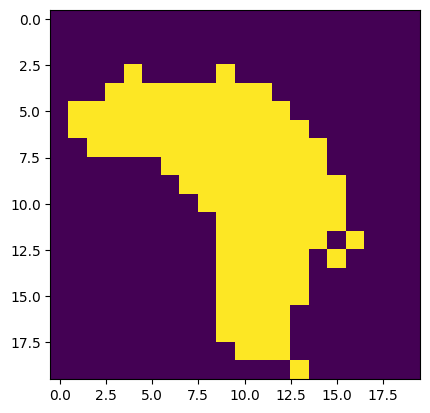

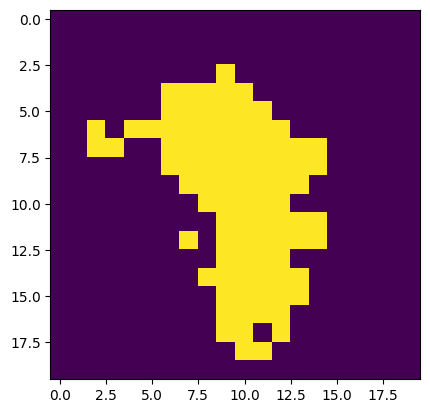

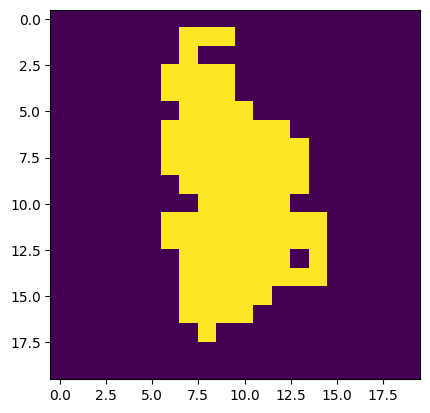

582

In [15]:
i = int(random.random() * len(data))

res = model.predict(data[i:i+1])[0]
res = np.where(res > 0.5, 1, 0)

plt.imshow(data[i][:400].reshape((20,20)))
plt.show()
plt.imshow(res.reshape((20,20)))
plt.show()
plt.imshow(label[i].reshape((20,20)))
plt.show()
i

In [13]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'model')